C:\Users\dodam\AppData\Local\Temp\ipykernel_26044\429425584.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = gdf[gdf["SGG_NM"].str.contains(city)].geometry.unary_union
C:\Users\dodam\AppData\Local\Temp\ipykernel_26044\429425584.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = gdf[gdf["SGG_NM"].str.contains(city)].geometry.unary_union
C:\Users\dodam\AppData\Local\Temp\ipykernel_26044\429425584.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = gdf.geometry.unary_union


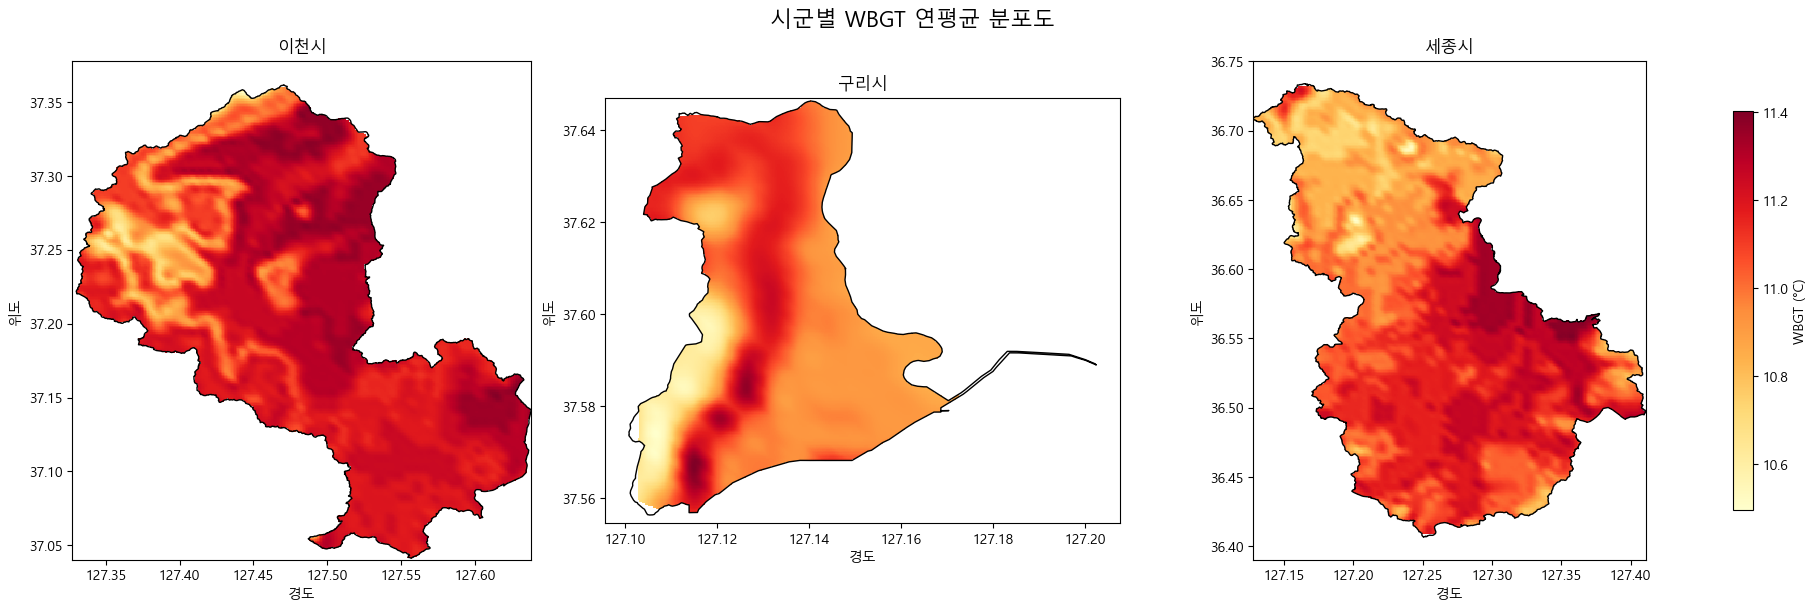

In [5]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from scipy.interpolate import griddata

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 1. 시군 설정 및 데이터 경로 매핑
regions = {
    "이천시": ("data/체감온도/이천시_WBGT.csv", "data/행정동경계_원천데이터/경기도/LARD_ADM_SECT_SGG_41_202505.shp"),
    "구리시": ("data/체감온도/구리시_WBGT.csv", "data/행정동경계_원천데이터/경기도/LARD_ADM_SECT_SGG_41_202505.shp"),
    "세종시": ("data/체감온도/세종시_WBGT.csv", "data/행정동경계_원천데이터/세종특별자치시/LARD_ADM_SECT_SGG_36_202505.shp"),
}

# 2. 전체 WBGT 범위 계산 (vmin, vmax)
all_wbgt = []
for csv_path, _ in regions.values():
    df = pd.read_csv(csv_path)
    all_wbgt.extend(df["WBGT"].values)

vmin = np.floor(min(all_wbgt) * 10) / 10
vmax = np.ceil(max(all_wbgt) * 10) / 10

# 3. subplot 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
fig.suptitle("시군별 WBGT 연평균 분포도", fontsize=16)

# 4. 각 subplot에 시각화
for ax, (city, (csv_path, shp_path)) in zip(axes, regions.items()):
    df = pd.read_csv(csv_path)
    lon, lat, wbgt = df["lon"], df["lat"], df["WBGT"]

    gdf = gpd.read_file(shp_path).to_crs("EPSG:4326")

    # 경계 추출 (세종시는 도시 이름 필터 생략)
    if city == "세종시":
        boundary = gdf.geometry.unary_union
    else:
        boundary = gdf[gdf["SGG_NM"].str.contains(city)].geometry.unary_union


    # 그리드 및 보간
    grid_lon = np.linspace(lon.min(), lon.max(), 300)
    grid_lat = np.linspace(lat.min(), lat.max(), 300)
    grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)
    grid_z = griddata((lon, lat), wbgt, (grid_x, grid_y), method="cubic")

    # 마스킹
    mask = np.array([[boundary.contains(Point(x, y)) for x in grid_lon] for y in grid_lat])
    masked_z = np.where(mask, grid_z, np.nan)

    # 시각화
    pcm = ax.pcolormesh(grid_x, grid_y, masked_z, cmap="YlOrRd", shading="auto")
    gpd.GeoSeries(boundary).boundary.plot(ax=ax, edgecolor="black", linewidth=1)

    ax.set_title(city)
    ax.set_xlabel("경도")
    ax.set_ylabel("위도")
    ax.set_aspect("equal")

# 5. 공통 colorbar 추가
cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), shrink=0.8, orientation="vertical", label="WBGT (°C)")

plt.show()

C:\Users\dodam\AppData\Local\Temp\ipykernel_26044\1066401299.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = gdf[gdf["SGG_NM"].str.contains(city)].geometry.unary_union
C:\Users\dodam\AppData\Local\Temp\ipykernel_26044\1066401299.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = gdf[gdf["SGG_NM"].str.contains(city)].geometry.unary_union
C:\Users\dodam\AppData\Local\Temp\ipykernel_26044\1066401299.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = gdf.geometry.unary_union


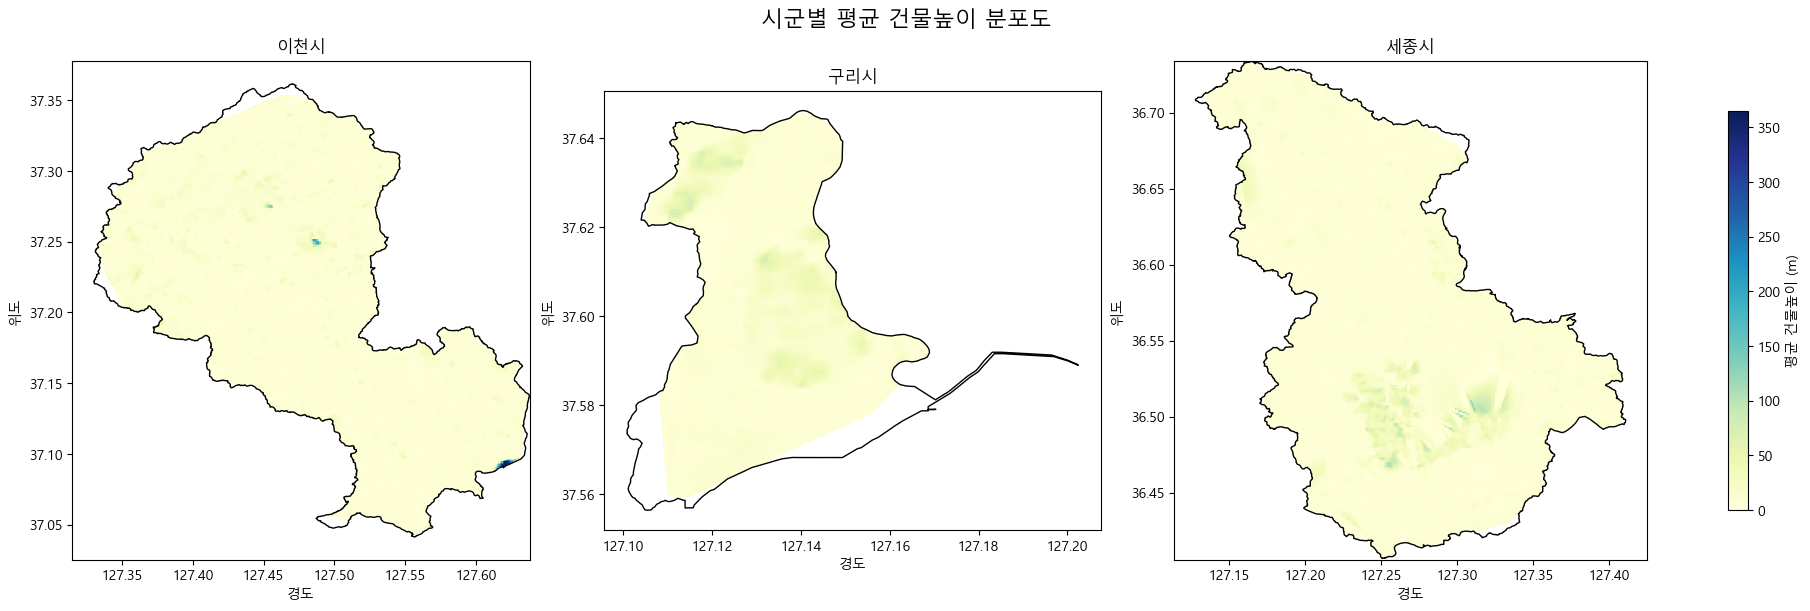

In [6]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from scipy.interpolate import griddata

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 1. 시군 설정 및 파일 경로 매핑
regions = {
    "이천시": ("data/건물높이/이천시_건물높이.csv", "data/행정동경계_원천데이터/경기도/LARD_ADM_SECT_SGG_41_202505.shp"),
    "구리시": ("data/건물높이/구리시_건물높이.csv", "data/행정동경계_원천데이터/경기도/LARD_ADM_SECT_SGG_41_202505.shp"),
    "세종시": ("data/건물높이/세종시_건물높이.csv", "data/행정동경계_원천데이터/세종특별자치시/LARD_ADM_SECT_SGG_36_202505.shp"),
}

# 2. 전체 건물 높이 범위 계산
all_heights = []
for csv_path, _ in regions.values():
    df = pd.read_csv(csv_path)
    all_heights.extend(df["avg_height"].dropna().values)

vmin = np.floor(min(all_heights) / 5) * 5  # 5 단위로 깔끔하게
vmax = np.ceil(max(all_heights) / 5) * 5

# colormap 설정
colormap = "YlGnBu"

# 3. subplot 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
fig.suptitle("시군별 평균 건물높이 분포도", fontsize=16)

# 4. 각 subplot 시각화
for ax, (city, (csv_path, shp_path)) in zip(axes, regions.items()):
    df = pd.read_csv(csv_path).dropna()
    x, y, height = df["x"], df["y"], df["avg_height"]

    gdf = gpd.read_file(shp_path).to_crs("EPSG:4326")

    if city == "세종시":
        boundary = gdf.geometry.unary_union
    else:
        boundary = gdf[gdf["SGG_NM"].str.contains(city)].geometry.unary_union

    # 좌표를 위경도로 변환 (EPSG:5179 → 4326 필요 시 처리)
    if x.max() > 200000:  # EPSG:5179의 특징적 x값
        from pyproj import Transformer
        transformer = Transformer.from_crs("EPSG:5179", "EPSG:4326", always_xy=True)
        lon, lat = transformer.transform(x.values, y.values)
    else:
        lon, lat = x, y

    # 보간용 그리드
    grid_lon = np.linspace(min(lon), max(lon), 300)
    grid_lat = np.linspace(min(lat), max(lat), 300)
    grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)
    grid_z = griddata((lon, lat), height, (grid_x, grid_y), method="cubic")

    # 마스킹
    mask = np.array([[boundary.contains(Point(x, y)) for x in grid_lon] for y in grid_lat])
    masked_z = np.where(mask, grid_z, np.nan)

    # 시각화
    pcm = ax.pcolormesh(grid_x, grid_y, masked_z, cmap=colormap, shading="auto", vmin=vmin, vmax=vmax)
    gpd.GeoSeries(boundary).boundary.plot(ax=ax, edgecolor="black", linewidth=1)

    ax.set_title(city)
    ax.set_xlabel("경도")
    ax.set_ylabel("위도")
    ax.set_aspect("equal")

# 5. 공통 colorbar 추가
fig.colorbar(pcm, ax=axes.ravel().tolist(), shrink=0.8, orientation="vertical", label="평균 건물높이 (m)")

plt.show()

In [1]:
import geopandas as gpd

# 파일 경로
shp_path = "data\행정동경계_원천데이터\경상북도\LSMD_ADM_SECT_UMD_47_202505.shp"

# GeoDataFrame으로 불러오기 (CP949 = euc-kr)
gdf = gpd.read_file(shp_path, encoding="euc-kr")

# 데이터프레임 요약
print(gdf.info())

# 상위 5개 행 미리보기
print(gdf.head())

<>:4: SyntaxWarning: invalid escape sequence '\L'
<>:4: SyntaxWarning: invalid escape sequence '\L'
C:\Users\dodam\AppData\Local\Temp\ipykernel_25896\2794725381.py:4: SyntaxWarning: invalid escape sequence '\L'
  shp_path = "data\행정동경계_원천데이터\경상북도\LSMD_ADM_SECT_UMD_47_202505.shp"


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EMD_CD      526 non-null    object  
 1   COL_ADM_SE  526 non-null    object  
 2   EMD_NM      526 non-null    object  
 3   SGG_OID     526 non-null    int32   
 4   geometry    526 non-null    geometry
dtypes: geometry(1), int32(1), object(3)
memory usage: 18.6+ KB
None
     EMD_CD COL_ADM_SE EMD_NM  SGG_OID  \
0  47940250      47940    울릉읍     1351   
1  47940310      47940     서면     1370   
2  47940320      47940     북면     1329   
3  47111102      47110    대도동      187   
4  47113115      47110    학잠동      186   

                                            geometry  
0  MULTIPOLYGON (((548330.177 555258.162, 548331....  
1  MULTIPOLYGON (((536347.764 553552.794, 536348....  
2  MULTIPOLYGON (((545174.039 557338.169, 545165....  
3  POLYGON ((412271.109 381240.014, 412274.664 38...

C:\Users\dodam\AppData\Local\Temp\ipykernel_25896\2211494776.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = gdf_dong_city.boundary.unary_union
C:\Users\dodam\AppData\Local\Temp\ipykernel_25896\2211494776.py:57: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  boundary.plot(ax=ax, color='black', linewidth=0.5)
C:\Users\dodam\AppData\Local\Temp\ipykernel_25896\2211494776.py:58: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_poi.plot(
C:\Users\dodam\AppData\Local\Temp\ipykernel_25896\2211494776.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = gdf_dong_city.boundary.unary_union


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Workspace/YCmeat/data/poi데이터/이천시_POI_통합.csv'

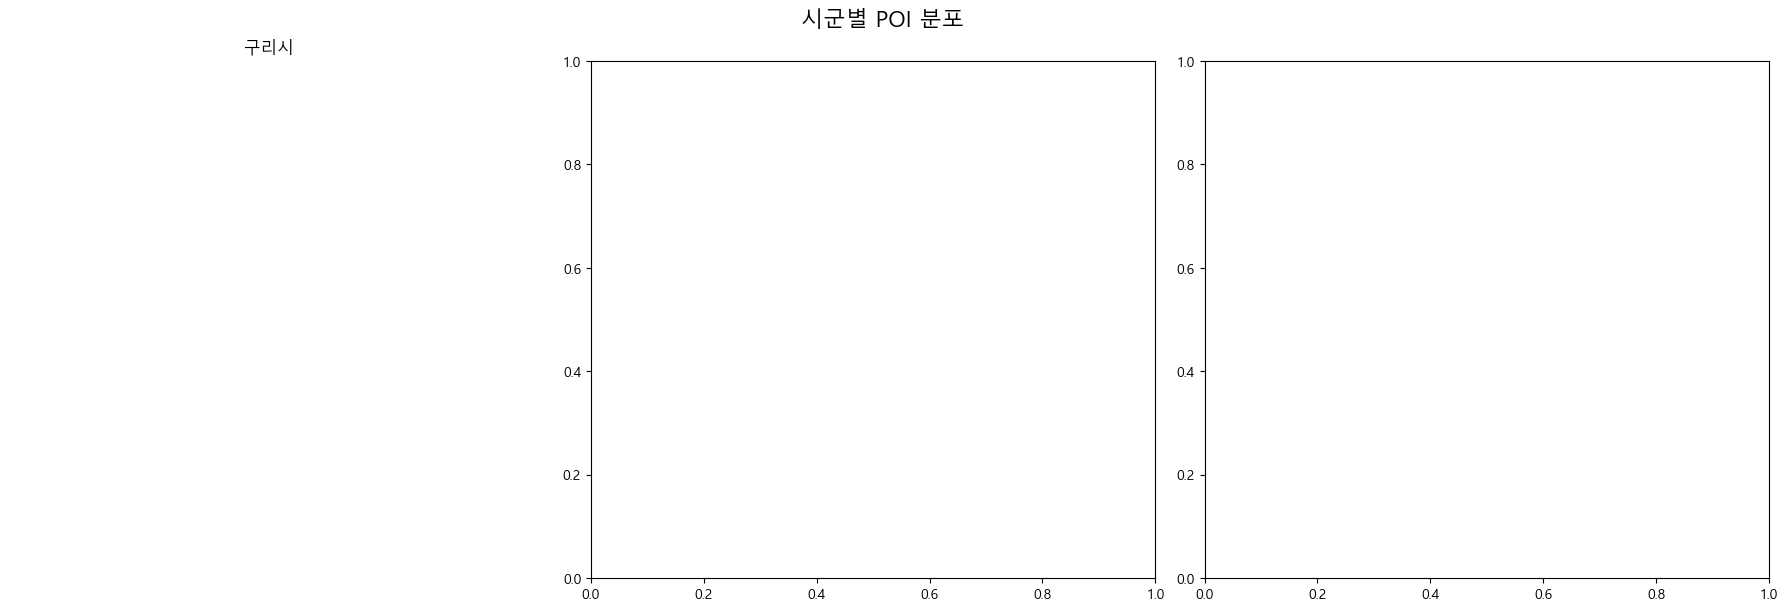

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# ▶ 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 지역별 데이터 경로 설정
regions = {
    "구리시": {
        "shp": "data/시군구경계_원천데이터/경기도/LARD_ADM_SECT_SGG_41_202505.shp",
        "dong": "data/행정동경계_원천데이터/경기도/LSMD_ADM_SECT_UMD_41_202505.shp",
        "poi": "C:/Workspace/YCmeat/data/poi데이터/구리시_POI_통합.csv",
        "adm_prefix": "31110"
    },
    "이천시": {
        "shp": "data/시군구경계_원천데이터/경기도/LARD_ADM_SECT_SGG_41_202505.shp",
        "dong": "data/행정동경계_원천데이터/경기도/LSMD_ADM_SECT_UMD_41_202505.shp",
        "poi": "C:/Workspace/YCmeat/data/poi데이터/이천시_POI_통합.csv",
        "adm_prefix": "41500"
    },
    "세종시": {
        "shp": "data/시군구경계_원천데이터/세종특별자치시/LARD_ADM_SECT_SGG_36_202505.shp",
        "dong": "data/행정동경계_원천데이터/세종시/LSMD_ADM_SECT_UMD_36_202505.shp",
        "poi": "C:/Workspace/YCmeat/data/poi데이터/세종시_POI_통합.csv",
        "adm_prefix": "29010"
    }
}

# 2. Subplot 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
fig.suptitle("시군별 POI 분포", fontsize=16)

# 3. 각 지역별 처리
for ax, (city, paths) in zip(axes, regions.items()):
    # 행정동 및 시군구 경계 불러오기
    gdf_dong = gpd.read_file(paths["dong"], encoding="euc-kr").to_crs(epsg=5181)
    gdf_sgg = gpd.read_file(paths["shp"], encoding="euc-kr").to_crs(epsg=5181)

    # 클립핑 및 필터링
    gdf_dong_city = gpd.clip(gdf_dong, gdf_sgg)
    gdf_dong_city = gdf_dong_city[gdf_dong_city["EMD_CD"].astype(str).str.startswith(paths["adm_prefix"])]
    boundary = gdf_dong_city.boundary.unary_union
    boundary = gpd.GeoSeries(boundary, crs=gdf_dong_city.crs)

    # POI 불러오기
    df_poi = pd.read_csv(paths["poi"])
    gdf_poi = gpd.GeoDataFrame(
        df_poi,
        geometry=gpd.points_from_xy(df_poi["lat"], df_poi["lon"]),
        crs="EPSG:4326"
    ).to_crs(epsg=5181)
    gdf_poi = gpd.clip(gdf_poi, gdf_sgg)

    # 시각화
    boundary.plot(ax=ax, color='black', linewidth=0.5)
    gdf_poi.plot(
        ax=ax,
        column="category_1st",
        categorical=True,
        legend=False,
        markersize=10,
        alpha=0.7
    )

    ax.set_title(city)
    ax.axis("off")

# 범례는 마지막 subplot 기준으로 공통 추가
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=10)

plt.show()

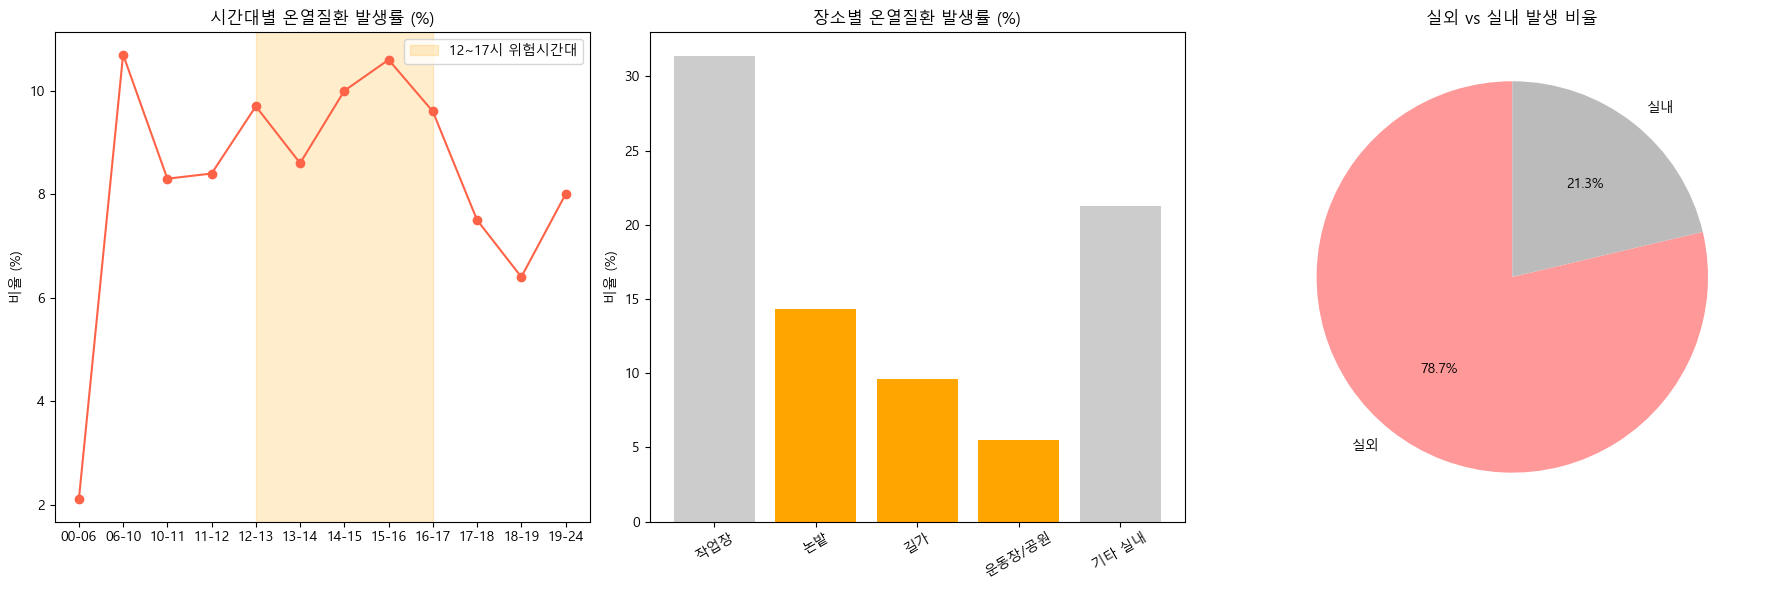

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 시간대별 온열질환 발생률
time_labels = [
    "00-06", "06-10", "10-11", "11-12", "12-13", "13-14",
    "14-15", "15-16", "16-17", "17-18", "18-19", "19-24"
]
time_values = [2.1, 10.7, 8.3, 8.4, 9.7, 8.6, 10.0, 10.6, 9.6, 7.5, 6.4, 8.0]

# 2. 장소별 온열질환 발생률 (세분화)
place_labels = [
    "작업장", "논밭", "길가", "운동장/공원", "기타 실내"
]
place_values = [31.4, 14.3, 9.6, 5.5, 21.3]

# 강조할 항목 인덱스
highlight_indices = [1, 2, 3]

# 색상 설정: 기본 회색, 강조 주황
colors = ['#cccccc'] * len(place_labels)
for i in highlight_indices:
    colors[i] = 'orange'

# 3. 실외 vs 실내 비율
group_labels = ['실외', '실내']
group_values = [78.7, 21.3]

# 시각화
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# (1) 시간대별 발생률
axs[0].plot(time_labels, time_values, marker='o', color='tomato')
axs[0].set_title('시간대별 온열질환 발생률 (%)')
axs[0].set_ylabel('비율 (%)')
axs[0].axvspan(4, 8, color='orange', alpha=0.2, label='12~17시 위험시간대')
axs[0].legend()

# (2) 장소별 발생률
axs[1].bar(place_labels, place_values, color=colors)
axs[1].set_title('장소별 온열질환 발생률 (%)')
axs[1].set_ylabel('비율 (%)')
axs[1].tick_params(axis='x', rotation=30)

# (3) 실외 vs 실내 비율
axs[2].pie(group_values, labels=group_labels, autopct='%1.1f%%',
           startangle=90, colors=['#ff9999', '#bbbbbb'])
axs[2].set_title('실외 vs 실내 발생 비율')

plt.tight_layout()
plt.show()


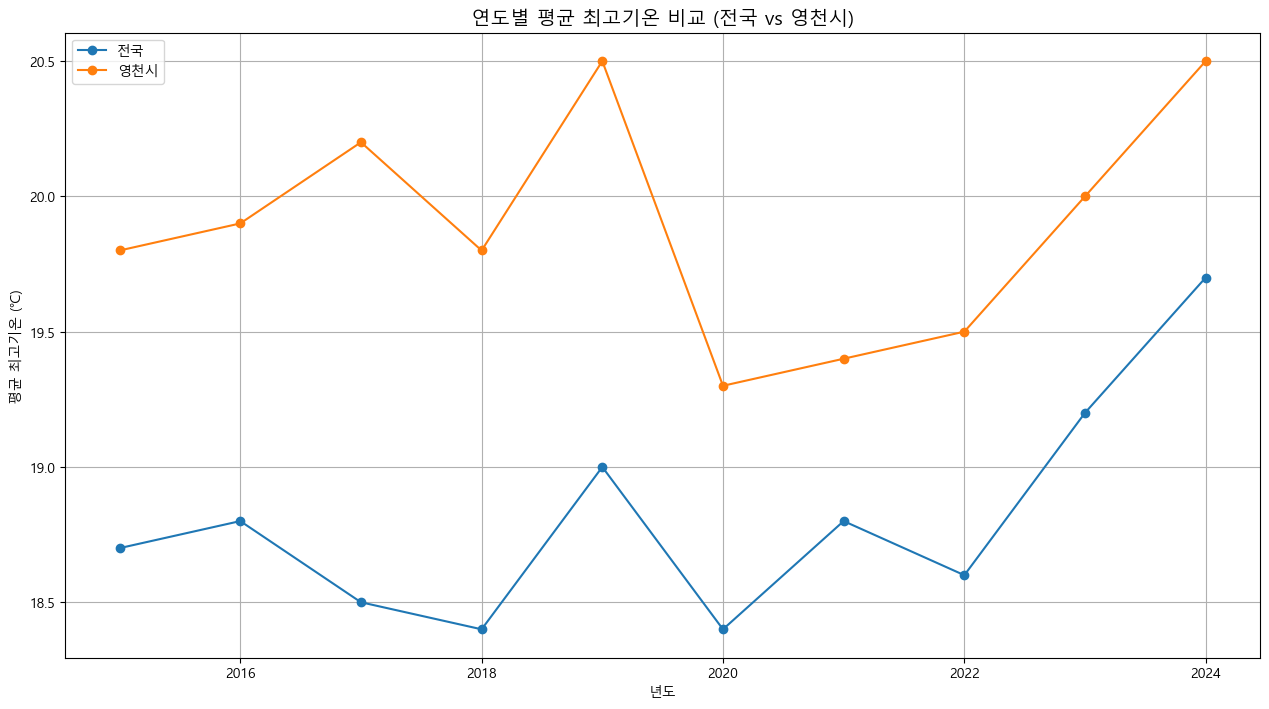

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 파일 경로
file_korea = "data/_etc/ta_20250610114033.csv"
file_yeongcheon = "data/_etc/ta_20250610114058.csv"

# CSV 파일 불러오기 (cp949 인코딩 + 메타데이터 건너뛰기)
df_korea = pd.read_csv(file_korea)
df_yeongcheon = pd.read_csv(file_yeongcheon)

# 연도별 평균 최고기온 시각화
plt.figure(figsize=(12.8, 7.2))
plt.plot(df_korea['년'], df_korea['평균최고기온(℃)'], marker='o', label='전국')
plt.plot(df_yeongcheon['년'], df_yeongcheon['평균최고기온(℃)'], marker='o', label='영천시')

plt.title('연도별 평균 최고기온 비교 (전국 vs 영천시)', fontsize=14)
plt.xlabel('년도')
plt.ylabel('평균 최고기온 (℃)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

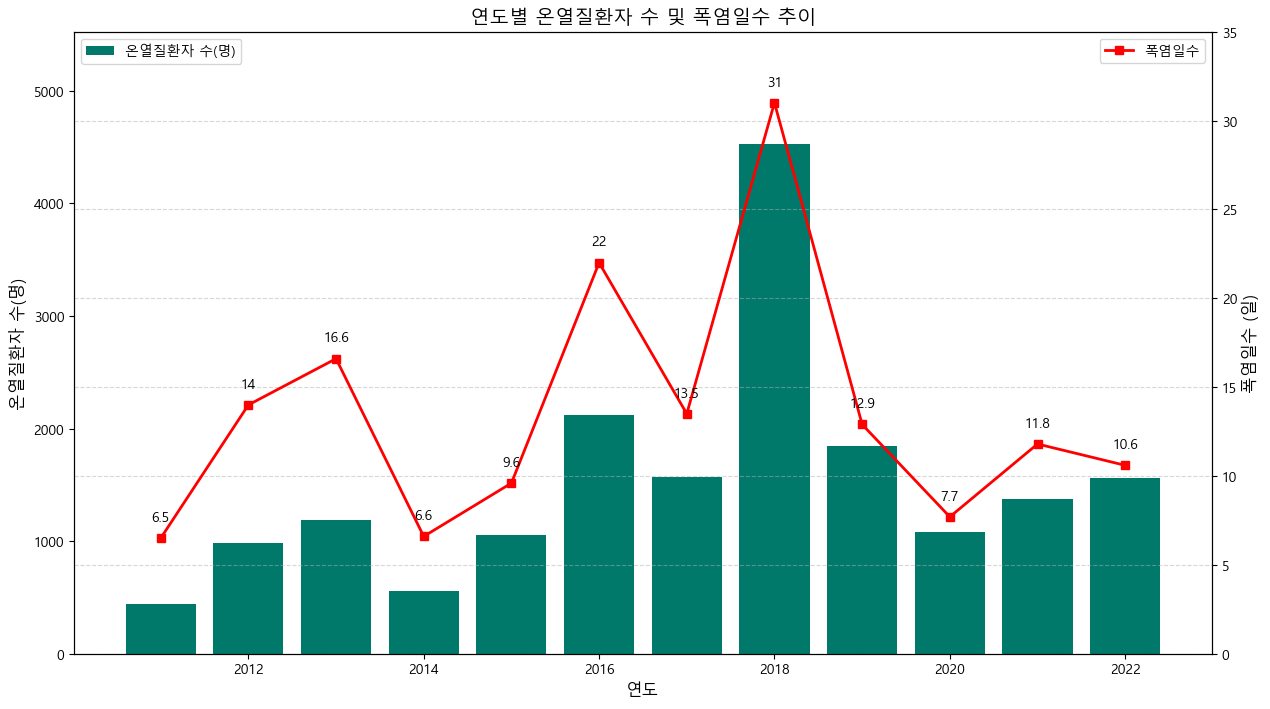

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터
years = list(range(2011, 2023))
patients = [443, 984, 1189, 556, 1056, 2125, 1574, 4526, 1841, 1078, 1376, 1564]
heat_days = [6.5, 14, 16.6, 6.6, 9.6, 22, 13.5, 31, 12.9, 7.7, 11.8, 10.6]

# 시각화 시작
fig, ax1 = plt.subplots(figsize=(12.8, 7.2))  # 16:9 비율

# 온열질환자 수 - 막대그래프
bars = ax1.bar(years, patients, color='#00796B', label='온열질환자 수(명)')
ax1.set_ylabel('온열질환자 수(명)', fontsize=12)
ax1.set_xlabel('연도', fontsize=12)
ax1.set_ylim(0, max(patients) + 1000)

# 막대 위에 값 표시
for i, v in enumerate(patients):
    ax1.text(years[i], v + 50, f"{v:,}", ha='center', va='bottom', fontsize=10, color='white')

# 폭염일수 - 선그래프 (이중축)
ax2 = ax1.twinx()
ax2.plot(years, heat_days, color='red', marker='s', linewidth=2, label='폭염일수')
ax2.set_ylabel('폭염일수 (일)', fontsize=12)
ax2.set_ylim(0, 35)

# 선 위에 값 표시
for i, v in enumerate(heat_days):
    ax2.text(years[i], v + 0.8, str(v), ha='center', va='bottom', fontsize=10, color='black')

# 범례
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('연도별 온열질환자 수 및 폭염일수 추이', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()